# LIM forecasting: Sea ice 

Katie Brennan  
started March 31, 2020  
  
#### Goals: 
* Build a LIM based on SIC 
* Build a LIM based on both SIC and SIT 
* Compare performance

In [1]:
import sys,os
#sys.path.append("/Users/hakim/gitwork/LMR_python3")
sys.path.append("/home/disk/kalman2/mkb22/pyLMR/")

In [2]:
from netCDF4 import Dataset, date2num, num2date
import numpy as np
import ESMF
import LMR_utils
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point

In [60]:
sys.path.append("/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/")
import LIM_utils as uLIM

In [79]:
import importlib
importlib.reload(uLIM)

<module 'LIM_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py'>

In [5]:
import time as timestamp # avoids conflict with local naming!

In [6]:
arc_proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                              central_longitude=-45,
                                              true_scale_latitude=0.1))
proj = dict(projection=ccrs.Robinson(central_longitude=0.),zorder=1)

In [7]:
from datetime import date

today = date.today()

#Year-month-day
today_date = today.strftime("%Y%m%d")
today_date

'20201020'

In [85]:
# Define of the name of the variable to use for the LIM
#var_to_extract = 'tas'
# tos is not working due to mask issues...
var_to_extract = 'sic'

# number of EOFs to retain for the LIM state vector
nmodes = 20

# forecast lead time in months that defines the LIM training
tau = 1

# training data defined by the first ntrain times
ntrain = 4000

# for the LIM readme
data_source = 'CCSM4 last millennium simulation'

save_dir = '/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/results/'

if not os.path.exists(save_dir+var_to_extract):
    os.makedirs(save_dir+var_to_extract)

In [86]:
pi = np.pi

# fill continents if plotting SST; otherwise no
if var_to_extract == 'tos':
    noland = True
else:
    noland = False
    
# netcdf file locations
#ccsm_dir = '/Users/hakim/data/LMR_python3/data/model/ccsm4_last_millenium/'
ccsm_dir = '/home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/'

infile_ccsm_tos = (ccsm_dir + 'tos_sfc_Omon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_tas = (ccsm_dir + 'tas_sfc_Amon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_z500 = (ccsm_dir + 'zg_500hPa_Amon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_pr = (ccsm_dir + 'pr_sfc_Amon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_ohc = (ccsm_dir + 'ohc_0-700m_Omon_CCSM4_past1000_085001-185012.nc')
infile_ccsm_sic = (ccsm_dir + 'sic_sfc_OImon_CCSM4_past1000_085001-185012.nc')

infile_20cr_tas = '/home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc'

In [12]:
#----------- end of function definitions --------------

In [13]:
#
# load CCSM4 past1000 data...
#
#data_in_tas,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_tas, 45, 72)
# data_in_z500,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_z500, 45, 72)
# data_in_pr,lat_2d,lon_2d = get_data(var_to_extract,infile_ccsm_pr, 45, 72)
#data_in_ohc,lat_2d,lon_2d = uLIM.get_data(var_to_extract,infile_ccsm_ohc, 45, 72)
#data_in_tos,lat_2d,lon_2d = uLIM.get_data(var_to_extract,infile_ccsm_tos, 45, 72)
data_in_sic,lat_2d,lon_2d = uLIM.get_data(var_to_extract,infile_ccsm_sic, 45, 72)

ntime = data_in_sic.shape[0]
nlat = data_in_sic.shape[1]
nlon = data_in_sic.shape[2]

fetching  sic  from  /home/disk/kalman3/rtardif/LMR/data/model/ccsm4_last_millenium/sic_sfc_OImon_CCSM4_past1000_085001-185012.nc
-----------------------------------------------------
completed in 29.32504439353943 seconds
-----------------------------------------------------
(12012, 180, 360)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 180
nlon: 360
(64800, 12012)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 2.3345866203308105 seconds
-----------------------------------------------------
Working on:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11


In [14]:
# reshape (nx,ntime)
X = np.moveaxis(np.reshape(data_in_sic,[ntime,nlat*nlon]),0,-1) 
print('Original shape: '+str(data_in_sic.shape))
print('Shape of X: '+str(X.shape))

Original shape: (12012, 45, 72)
Shape of X: (3240, 12012)


In [15]:
X_nonan = np.where(np.isnan(X.data),0,X.data)
X_nonan_arctic = X_nonan
X_nonan_arctic[np.where(lat_2d.reshape(nlat*nlon)<0),:] = 0

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


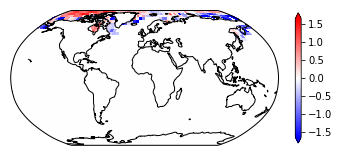

In [16]:
uLIM.plot_map_vector(X_nonan_arctic[:,].data,lat_2d,lon_2d)

In [17]:
u,s,v,W = uLIM.calc_eof(X_nonan_arctic, lat_2d)

computing EOFs...
-----------------------------------------------------
completed in 24.213696002960205 seconds
-----------------------------------------------------
(3240, 3240) (3240,) (3240, 12012)


In [18]:
# check SVD
print('checking svd (success for True response)...')
X_check = np.matmul(np.matmul(u,np.diag(s)),v)
print(np.allclose(X_check,W*X_nonan))

checking svd (success for True response)...
True


100.00000000000003
fraction in first  20  EOFs =  52.75923306593896


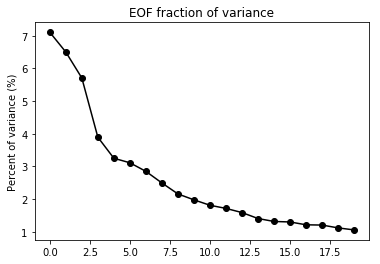

In [19]:
uLIM.plot_eigenvalues(s,nmodes,var_to_extract)

plt.savefig((save_dir+var_to_extract+'/'+var_to_extract+
             '_eigenvalue_spectra_'+today_date+'.png'),dpi=300)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


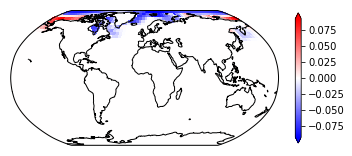

In [20]:
uLIM.plot_map_vector(-u[:,0],lat_2d,lon_2d)

In [21]:
# project data onto a subset of the EOF basis

# EOF basis
if var_to_extract == 'tos':
    E = u[:,1:nmodes+1]
else:
    E = u[:,0:nmodes]

# project---this doesn't work for tos? masked array/nan issue I don't understand
#P = np.matmul(E.T,X)

# alternative from SVD results. recall v is v.T in numpy. 
# NOTE: this is the projection with W weighting, which is not the same as projecting unweighted data

# 7/13/2020: projection of unweighted data; tos doesn't work with this approach
if var_to_extract == 'tos':
    #P_w = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
    P = np.matmul(np.diag(s[1:nmodes+1]),v[1:nmodes+1,:])
else:
    #P_w = np.matmul(np.diag(s[0:nmodes]),v[0:nmodes,:])
    P = np.matmul(E.T,X_nonan)

20.840946530053486
(3240, 12012)


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


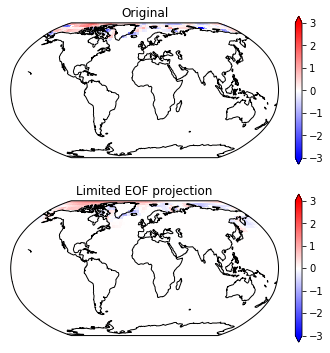

In [22]:
# reconstruct from the limited projection, and compare with the original (error)
check = np.matmul(E,P)
print(np.max(check))
print(check.shape)

# pick a random time to plot
itim = 21

fig,ax = plt.subplots(2,1, figsize=(6,6), subplot_kw = proj)

uLIM.subplot_map_vector(ax[0],fig,X_nonan[:,itim],lat_2d,lon_2d,maxv=3)
ax[0].set_title('Original')
uLIM.subplot_map_vector(ax[1],fig,check[:,itim],lat_2d,lon_2d,maxv=3)
ax[1].set_title('Limited EOF projection')

plt.savefig(save_dir+var_to_extract+'/'+var_to_extract+'_eof_proj_origVSlimited_randtime_'+today_date+'.png',dpi=300)

In [23]:
# make sure P has zero mean first !!!
Pzero = np.max(np.abs(np.mean(P,axis=1)))
if Pzero > 1e-6:
    print('warning!!! the projected state does not have zero-mean in the time domain '
         )

In [24]:
# prepare the data to train and test the LIM. separate data into training the validation sets 
tsamp = P.shape[1]

train_inds = np.arange(0,ntrain)
valid_inds = np.arange(ntrain,tsamp,1)
x_train = P[:,train_inds]
x_valid = P[:,valid_inds]
print('training data shape: ',x_train.shape)
print('validation data shape: ',x_valid.shape)

training data shape:  (20, 4000)
validation data shape:  (20, 8012)


In [25]:
# climo standardized variance for error normalization in training and validation (1=no skill)
train_var = np.var(np.matmul(E,x_train),axis=1,ddof=1)
valid_var = np.var(np.matmul(E,x_valid),axis=1,ddof=1)

In [87]:
# train the LIM
LIMd = uLIM.LIM_train(tau,x_train)

In [88]:
# LIM forecasts for a range of monthly values (can specify a list of arbitrary values too)
lags = np.arange(13)
#lags = [0,3,6,12]
ntims = len(lags)

# training data
LIMfd_train = uLIM.LIM_forecast(LIMd,x_train,lags,E)

# validation data
LIMfd_valid = uLIM.LIM_forecast(LIMd,x_valid,lags,E)

t= 0
t=

/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:283: ComplexWarning: Casting complex values to real discards the imaginary part
  x_predict_save[k,:,:] = x_predict


 1


/home/disk/p/mkb22/Documents/si_analysis_kb/LIMs/SI_LIMs/LIM_utils.py:286: ComplexWarning: Casting complex values to real discards the imaginary part
  x_predict_save[k,:,:-t] = x_predict


t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12
t= 0
t= 1
t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


In [89]:
# proper area-weighted global-mean values, including climo variance
LIMfd_train_error_3d = np.reshape(LIMfd_train['error'],[nlat,nlon,ntims])
LIMfd_valid_error_3d = np.reshape(LIMfd_valid['error'],[nlat,nlon,ntims])

[train_gm_err,
 train_nh_err,
 train_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_train_error_3d,-1,0),lat_2d[:,0])
[train_gm_var,
 train_nh_var,
 train_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(train_var[:,None],[nlat,nlon]),lat_2d[:,0])
[valid_gm_err,
 valid_nh_err,
 valid_sh_err] = LMR_utils.global_hemispheric_means(np.moveaxis(LIMfd_valid_error_3d,-1,0),lat_2d[:,0])
[valid_gm_var,
 valid_nh_var,
 valid_sh_var] = LMR_utils.global_hemispheric_means(np.reshape(valid_var[:,None],[nlat,nlon]),lat_2d[:,0])


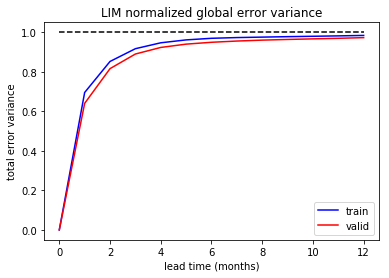

In [93]:
# plot global-mean normalized error variance
plt.plot(lags,train_nh_err/train_nh_var,'b-',label='train')
plt.plot(lags,valid_nh_err/valid_nh_var,'r-',label='valid')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
plt.savefig((save_dir+var_to_extract+'/'+var_to_extract+'_gm_error_variance_eof'+
             str(nmodes)+'_tau'+str(tau)+'_'+today_date+'.png'),dpi=300)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


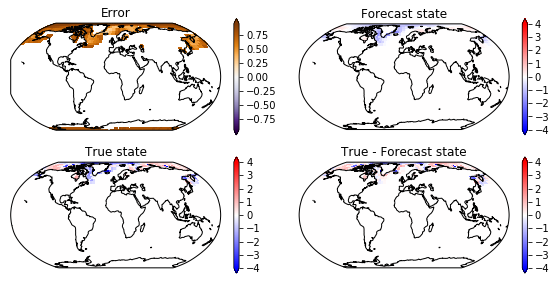

In [91]:
fig,ax = plt.subplots(2,2, figsize=(8,4), subplot_kw = proj)
ax = ax.flatten()
ilag = 1
uLIM.subplot_map_vector(ax[0],fig,LIMfd_train['error'][:,ilag]/train_var,
                        lat_2d,lon_2d,cmap='PuOr_r')
ax[0].set_title('Error')

itime = 1
uLIM.subplot_map_vector(ax[1],fig,np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),
                        lat_2d,lon_2d,maxv=4)
ax[1].set_title('Forecast state')

uLIM.subplot_map_vector(ax[2],fig,X_nonan[:,itime],lat_2d,lon_2d,maxv=4)
ax[2].set_title('True state')

uLIM.subplot_map_vector(ax[3],fig,X_nonan[:,itime]-np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),
                        lat_2d,lon_2d,maxv=4)
ax[3].set_title('True - Forecast state')
plt.tight_layout()

plt.savefig((save_dir+var_to_extract+'/'+var_to_extract+
             '_error_global_spatial_plots_randtime_eof'+str(nmodes)+'_tau'+
             str(tau)+'_'+today_date+'.png'),dpi=300)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)


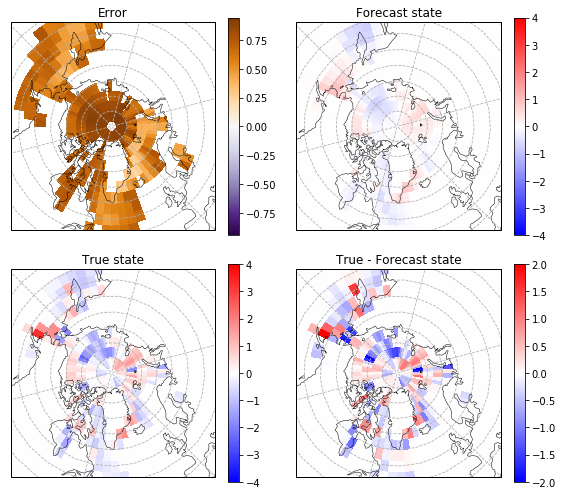

In [92]:
fig,ax = plt.subplots(2,2, figsize=(8,7), subplot_kw = arc_proj)
ax = ax.flatten()
ilag = 1

uLIM.sub_arctic_plot(ax[0],fig,LIMfd_train['error'][:,ilag]/train_var,
                        lat_2d,lon_2d,minv=-1, maxv=-1,cmap='PuOr_r')
ax[0].set_title('Error')

itime = 100
uLIM.sub_arctic_plot(ax[1],fig,np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),
                        lat_2d,lon_2d,minv=-4, maxv=4)
ax[1].set_title('Forecast state')

uLIM.sub_arctic_plot(ax[2],fig,X_nonan[:,itime],lat_2d,lon_2d,minv=-4, maxv=4)
ax[2].set_title('True state')

uLIM.sub_arctic_plot(ax[3],fig,X_nonan[:,itime]-np.matmul(E,LIMfd_train['x_forecast'][ilag,:,itime]),
                        lat_2d,lon_2d,minv=-2, maxv=2)
ax[3].set_title('True - Forecast state')
plt.tight_layout()

plt.savefig((save_dir+var_to_extract+'/'+var_to_extract+
             '_error_arctic_spatial_plots_randtime_eof'+str(nmodes)+'_tau'+
             str(tau)+'_'+today_date+'.png'),dpi=300)

## Independent validation: 

In [39]:
# load 20cr data for independent validation...
data_20cr,_,_ = get_data(var_to_extract,infile_20cr_tas, 45, 72)
ntime_20cr = data_20cr.shape[0]

fetching  tas  from  /home/disk/kalman3/rtardif/LMR/data/model/20cr/tas_sfc_Amon_20CR_185101-201112.nc
-----------------------------------------------------
completed in 0.7526452541351318 seconds
-----------------------------------------------------
(1932, 91, 180)
indlat= 0  indlon= 1
('lat', 'lon')
nlat: 91
nlon: 180
(16380, 1932)
Mask detected.  Adding mask to src ESMF grid
-----------------------------------------------------
completed in 0.3795194625854492 seconds
-----------------------------------------------------
Working on:
month = 0
month = 1
month = 2
month = 3
month = 4
month = 5
month = 6
month = 7
month = 8
month = 9
month = 10
month = 11


In [41]:
# back to (nx,ntime)
X_20cr = np.moveaxis(np.reshape(data_20cr,[ntime_20cr,nlat*nlon]),0,-1) 

# test the LIM on 20CR monthly data projected on the same basis
P_20cr = np.matmul(E.T,X_20cr)

# climo standardized variance
valid_var_20cr = np.var(np.matmul(E,P_20cr),axis=1,ddof=1)

In [43]:
# CCSM LIM forecasts on 20cr states
LIMfd_20cr = LIM_forecast(LIMd,P_20cr,lags,E)

t= 0
t= 1


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray_test/lib/python3.6/site-packages/ipykernel_launcher.py:38: ComplexWarning: Casting complex values to real discards the imaginary part


t= 2
t= 3
t= 4
t= 5
t= 6
t= 7
t= 8
t= 9
t= 10
t= 11
t= 12


In [44]:
# proper area-weighted global-mean values
valid_gm_err_20cr,_,_ = LMR_utils.global_hemispheric_means(np.moveaxis(np.reshape(LIMfd_20cr['error'],[nlat,nlon,ntims]),-1,0),lat_2d[:,0])
valid_gm_var_20cr,_,_ = LMR_utils.global_hemispheric_means(np.reshape(valid_var_20cr[:,None],[nlat,nlon]),lat_2d[:,0])


Text(0.5,1,'LIM normalized global error variance')

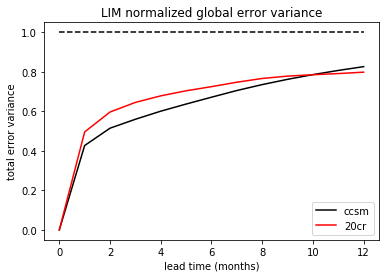

In [45]:
plt.plot(lags,valid_gm_err/valid_gm_var,'k-',label='ccsm')
plt.plot(lags,valid_gm_err_20cr/valid_gm_var_20cr,'r-',label='20cr')
plt.plot([lags[0],lags[-1]],[1,1],'k--')
plt.xlabel('lead time (months)')
plt.ylabel('total error variance')
plt.legend()
plt.title('LIM normalized global error variance')
#plt.savefig('LIM_forecast_error_ccsm_20cr_6mo',dpi=300)